In [1]:
import torch
import os
from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.loader import DataLoader


name = "MUTAG"
path='../data'
train_size = 10
test_size = 50
batch_size = 32


dataset = TUDataset(os.path.join(path, 'TUDataset'), name=name)
torch.manual_seed(1712)
dataset = dataset.shuffle()

if train_size and test_size:
    train_dataset = dataset[:train_size]
    test_dataset = dataset[train_size:train_size + test_size]
else:
    train_dataset = dataset[:int(0.8 * len(dataset))]
    test_dataset = dataset[int(0.8 * len(dataset)):]
    
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

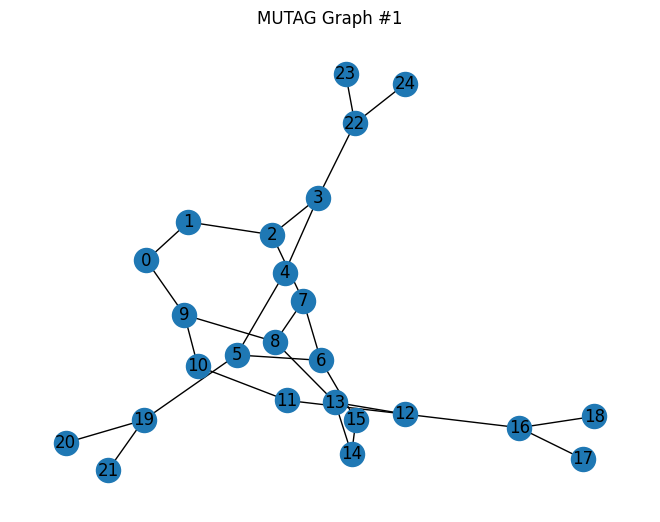

In [2]:
import os
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# 2. Pick one example (e.g. the first)
data = dataset[0]

# 3. Convert to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# 4. Plot it
plt.figure()
nx.draw(G, with_labels=True)
plt.title("MUTAG Graph #1")
plt.show()

In [11]:
dataset[0]

Data(edge_index=[2, 56], x=[25, 7], edge_attr=[56, 4], y=[1])

In [12]:
print(f"Node features: {dataset[0].x[:2]}")
print(f"Edage attribute: {dataset[0].edge_attr[:2]}")

Node features: tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])
Edage attribute: tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.]])


In [13]:
from torch_geometric.utils import degree

# Get max degree over all graphs
max_deg = 0
for data in dataset:
    deg = degree(data.edge_index[0], num_nodes=data.num_nodes)
    max_deg = max(max_deg, int(deg.max()))

print(f"Maximum degree: {max_deg}")

Maximum degree: 4


In [27]:
edge_index = dataset[0].edge_index.t()
num_nodes = dataset.x.size(0)
num_nodes_model = 5
num_edges_model = num_nodes_model - 1

In [28]:
adj_mtx = torch.zeros((num_nodes, num_nodes), dtype=torch.int)
adj_mtx[edge_index[:, 0], edge_index[:, 1]] = 1
adj_mtx[edge_index[:, 1], edge_index[:, 0]] = 1

In [29]:
from utils import star_subgraph
subgraphs = star_subgraph(adj_mtx.cpu().numpy(), subgraph_size=num_nodes_model)
print(f"Subgraph size: {subgraphs[0]}")

Subgraph size: [2682]


In [30]:
largest = max(subgraphs, key=len)
print(f"Largest subgraph (size {len(largest)}): {largest}")

Largest subgraph (size 4): [7, 2, 6, 8]


# Main

In [15]:
import pennylane as qml

from data import load_dataset

In [8]:
graphlet_size = 5
node_qubit = graphlet_size
edge_qubit = node_qubit - 1
n_qubits = node_qubit + edge_qubit
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
q_dev = qml.device("default.qubit", wires=n_qubits + 2) # number of ancilla qubits


num_ent_layers = 1
num_gnn_layers = 2

# PQC weight shape settings
w_shapes_dict = {
    'spreadlayer': (0, n_qubits, 1),
    'strong': (2, num_ent_layers, 3, 3), # 3
    # 'strong': (3, args.num_ent_layers, 2, 3), # 2
    'inits': (1, 4),
    'update': (1, num_ent_layers, 3, 3), # (1, args.num_ent_layers, 2, 3)
    'twodesign': (0, num_ent_layers, 1, 2)
}

node_input_dim = dataset[0].x.shape[1] if dataset[0].x is not None else 0
edge_input_dim = dataset[0].edge_attr.shape[1] if dataset[0].edge_attr is not None else 0
num_classes = dataset.num_classes

In [19]:
from model_test import QGNNGraphClassifier

model = QGNNGraphClassifier(
                q_dev=q_dev,
                w_shapes=w_shapes_dict,
                node_input_dim=node_input_dim,
                edge_input_dim=edge_input_dim,
                graphlet_size=node_qubit,
                hop_neighbor=num_gnn_layers,
                num_classes=num_classes,
                one_hot=0
            )

In [20]:
lr = 0.001
step_size = 2
gamma = 0.85

In [21]:
import torch
from torch import nn, optim

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
criterion = nn.CrossEntropyLoss()

In [28]:
dataset, train_loader, test_loader, task_type = load_dataset(
    name='MUTAG',
    path='../data',
    train_size=10,
    test_size=2,
    batch_size=32
)

In [ ]:
model.train()
total_loss = 0
for data in train_loader:
    data = data.to(device)
    optimizer.zero_grad()
    out = model(data.x, data.edge_attr, data.edge_index, data.batch)
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    total_loss += float(loss)  * data.num_graphs

In [31]:
total_loss / len(train_loader.dataset)

0.7950543761253357

In [ ]:
# Check gradients
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"{name} gradient: {'OK' if param.grad is not None and param.grad.abs().sum() > 0 else 'Missing or zero'}")

qconvs.lay1.spreadlayer gradient: Missing or zero
qconvs.lay1.strong gradient: OK
qconvs.lay1.inits gradient: OK
qconvs.lay1.update gradient: OK
qconvs.lay1.twodesign gradient: Missing or zero
qconvs.lay2.spreadlayer gradient: Missing or zero
qconvs.lay2.strong gradient: OK
qconvs.lay2.inits gradient: OK
qconvs.lay2.update gradient: OK
qconvs.lay2.twodesign gradient: Missing or zero
upds.lay1.lins.0.weight gradient: OK
upds.lay1.lins.0.bias gradient: OK
upds.lay1.lins.1.weight gradient: OK
upds.lay1.lins.1.bias gradient: OK
upds.lay2.lins.0.weight gradient: OK
upds.lay2.lins.0.bias gradient: OK
upds.lay2.lins.1.weight gradient: OK
upds.lay2.lins.1.bias gradient: OK
norms.lay1.weight gradient: Missing or zero
norms.lay1.bias gradient: Missing or zero
norms.lay2.weight gradient: Missing or zero
norms.lay2.bias gradient: Missing or zero
input_node.lins.0.weight gradient: OK
input_node.lins.0.bias gradient: OK
input_node.lins.1.weight gradient: OK
input_node.lins.1.bias gradient: OK
input_

: 

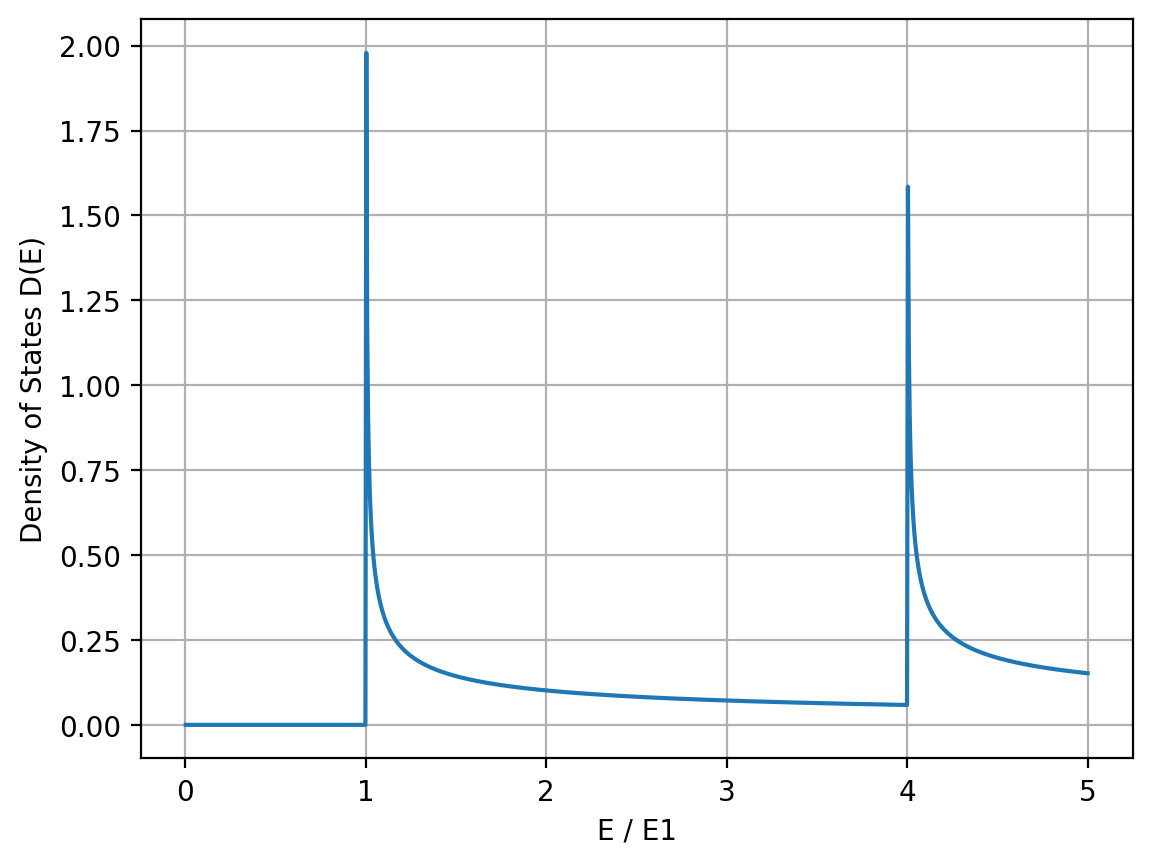

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
hbar = 1
m = 1
a = 1
E1 = (np.pi**2 * hbar**2) / (2 * m * a**2)

E = np.linspace(0.01, 5*E1, 1000)
D = np.zeros_like(E)

for n in range(1, 4):  # up to n=3 (E3 = 9*E1)
    En = n**2 * E1
    valid = E > En
    D[valid] += 1 / (np.pi * hbar * np.sqrt(2*m*(E[valid] - En)))

plt.plot(E/E1, D)
plt.xlabel('E / E1')
plt.ylabel('Density of States D(E)')
# plt.title('DoS for 2D Electron Waveguide')
plt.rcParams["figure.dpi"] = 600
plt.grid(True)
plt.show()